# Machine Learning in Python - Group Project 1

Github link: https://github.com/monicasteph97/mlp-project-1-group-45

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

## General Setup

In [1]:
# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules that are necessary. use sklearn==1.2.1
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn import set_config

# Other modules that are necessary
from difflib import get_close_matches
from bs4 import BeautifulSoup
from numpy.linalg import norm
import re
import requests
import warnings
import spacy
import forestci as fci

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.set_theme(style='darkgrid')
%matplotlib inline
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Others
warnings.filterwarnings('ignore')
set_config(transform_output='pandas')

In [2]:
# Load the spaCy model
nlp = spacy.load('en_core_web_lg')

In [3]:
# Load data
data = pd.read_csv('the_office.csv')
data_guest_star = pd.read_csv('guest_duration_office.csv')

## 1. Introduction

The aim of this project to advise NBC Universal on how to create the best reunion episode for the world's famous sitcom The Office (US). To do this we will explore and outline factors that make an episode popular. Namely, using the episode's IMDB rating as a basis to measure popularity and exploring different factors affecting it, such as which director, number of words spoken and main characters will produce a mroe popular episode. We will then build an understandable and validated model for the IMBD rating as the outcome of interest using features from 'the_office.csv' and 'guest_duration_office.csv'. 

From the 'guest_duration.csv' file we added the following parameters to our dataframe:

1. Viewership - The live viewership when the episode aired. We included this because we found it has a strong correlation to IMDB rating.
2. GuestStars - A list of any guest stars in the episode. We included this to explore any guest stars that have a strong impact on the IMBD rating. We can then add a recommendation to NBC for any beloved guest stars to include in the reunion episode.
3. Duration - The length of the episode. This was added as we can easily find an optimal epsiode duration to recommend to NBC.

The breakdown of the report is as follows:

- [**Section 2: Exploratory data analysis and feature engineering:**](#2) The objective of this section is to explore the data. This includes finding correlations and relationships amongst features, and identifying key factors affecting IMDB rating. We will also clean the data by removing duplicates, fixing spelling errors amongst other minor changes. On this validated data, we extract features to produce more statistical and impactful features based on data. Finally, we construct the pipeline to standardise, encode and reduce the dimension of data, as a groundwork for the following section.
- [**Section 3: Model Fitting and Tuning:**](#3) This section aims to choose the most appropriate model for our data, tune the hyperparameters involved, finalise the model with the set of optimal hyperparameters, fit the data into the model, and evaluating its performance on the training and test set.
- [**Section 4: Discussion and conclusion**](#4): This section provides several recommendations for NBC to produce a high IMDB rating for their reunion episode based on the insights that we have gathered from other sections.
- [**Section 5: References**](#5): This section provides any references used throughout the report. This can include refernces both for code and for text.

## <a id=2> 2. Exploratory Data Analysis and Feature Engineering </a>

The following section reviews and analyzes the data to ensure it is preprocessed appropriately for the model in section 3. Two data sets are viewed, analyzed, preprocessed, and then combined to create the final data set that will be viewed. The first data set is 'the_office.csv' (which is in the pandas dataframe 'data') originally given in the folder provided for this project. The other data set is 'guest_duration_office.csv' (which is in the pandas dataframe 'data_guest_star'). This dataset contains much of the same information, such as episode title and season, however, it also contains the guest stars that appear in each episode, the viewership and duration of each episode which will be included as features in our dataset. Both data sets are described in further detail in subsection 2.1. The datasets are cleaned separately based on our observations in section 2.1 and then merged based on episode title. Correlations among features are investigated, and then feature extraction is conducted to extract highly correlated features and add any new features that are deemed relevant based off current exploration. Finally, the numeric columns are standardized and the categorical columns are encoded. This section will ensure that the data is appropriately analyzed, cleaned and preprocessed so that it is ready for our model

The section is broken down into the following subsections:

- [**2.1. Data Exploration**](#21): Provide an overview of data sets 'data' and 'data_guest_star'. The data is described by giving statistics, unique values for each column and data structure so that readers can better understand the data and to identify any necessary data cleaning.
- [**2.2. Data Cleaning**](#22): Clean the data based on data exploration.
- [**2.3. Data Correlation**](#23): Understand the correlation among all the features.
- [**2.4. Feature Extraction**](#24): Extract highly correlated features and add new features based on given features.
- [**2.5. Feature Scaling and Selection**](#25): Standardize numeric values and encode categorical values.

### <a id=21>  2.1. Data Exploration </a>

This subsection aims to provide a comprehensive view of the datasets 'data' and 'data_guest_star' using the `describe_data` function. The objective of this section is to identify whether any data cleansing needs to be performed on the data (e.g., fixing typo, null values imputation, etc.) before feeding it into the model.

The data structure, sample, unique values, and histograms of the dataset are also provided. This is all to help identify any data cleaning that might be necessary. First the dataset 'data' (which is the data from 'the_office.csv') is viewed, and then the dataset 'data_guest_star' (which is the data from 'guest_duration_office') is viewed.


In [4]:
def describe_data(data):
    """
    Parameters
    ----------
    data: Raw data (pandas.DataFrame)
    """
    data_length = len(data)
    
    print('----- Data Structure -----')
    display(data.info())
    
    data_num = data.select_dtypes(include=['float64', 'int64'])
    if len(data_num.columns) > 0:
        print('----- Histogram -----')
        fig, ax = plt.subplots(1, len(data_num.columns), figsize=(15,3))
        fig.tight_layout(w_pad=2)
        for i, col in enumerate(data_num.columns):
            sns.histplot(data_num[col], ax=ax[i])
        plt.show()
    
    print('----- Unique Values -----')
    for col in data.columns:
        unique_vals = sorted(data[col].dropna().unique())
        length_unique_vals = len(unique_vals)
        
        print(f'{col} has {length_unique_vals} unique values.')
            
    print('----- Sample: Row 20-22 -----')
    display(data.loc[20:22])

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


None

----- Histogram -----


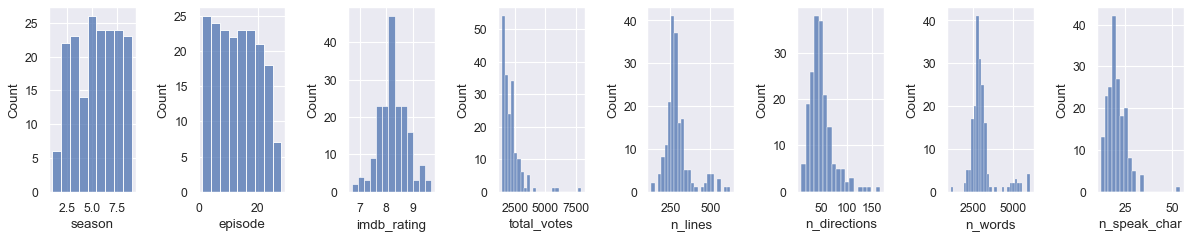

----- Unique Values -----
season has 9 unique values.
episode has 28 unique values.
episode_name has 186 unique values.
director has 61 unique values.
writer has 47 unique values.
imdb_rating has 28 unique values.
total_votes has 174 unique values.
air_date has 184 unique values.
n_lines has 119 unique values.
n_directions has 75 unique values.
n_words has 174 unique values.
n_speak_char has 22 unique values.
main_chars has 122 unique values.
----- Sample: Row 20-22 -----


,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
20,2,15,Boys & Girls,Dennie Gordon,B.J. Novak,8.2,2323,2006-02-02,281,20,3063,21,Angela;Darryl;Dwight;Jim;Kelly;Kevin;Meredith;...
21,2,16,Valentine's Day,Greg Daniels,Michael Schur,8.3,2345,2006-02-09,198,50,2482,18,Angela;Dwight;Jim;Kelly;Kevin;Meredith;Michael...
22,2,17,Dwight's Speech,Charles McDougal,Paul Lieberstein,8.4,2463,2006-03-02,206,27,2612,16,Angela;Creed;Dwight;Jim;Kelly;Kevin;Michael;Os...


In [5]:
describe_data(data)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    188 non-null    int64  
 1   Season        188 non-null    int64  
 2   EpisodeTitle  188 non-null    object 
 3   About         188 non-null    object 
 4   Ratings       188 non-null    float64
 5   Votes         188 non-null    int64  
 6   Viewership    188 non-null    float64
 7   Duration      188 non-null    int64  
 8   Date          188 non-null    object 
 9   GuestStars    29 non-null     object 
 10  Director      188 non-null    object 
 11  Writers       188 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.8+ KB


None

----- Histogram -----


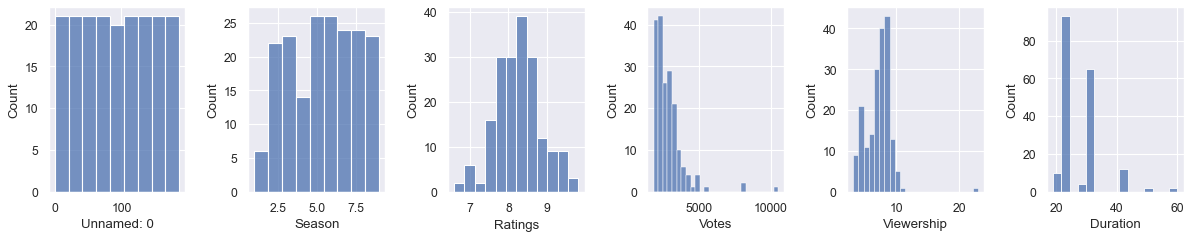

----- Unique Values -----
Unnamed: 0 has 188 unique values.
Season has 9 unique values.
EpisodeTitle has 188 unique values.
About has 188 unique values.
Ratings has 30 unique values.
Votes has 178 unique values.
Viewership has 149 unique values.
Duration has 13 unique values.
Date has 184 unique values.
GuestStars has 28 unique values.
Director has 54 unique values.
Writers has 47 unique values.
----- Sample: Row 20-22 -----


,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
20,20,2,Boys and Girls,Jan comes into the Scranton Branch to give all...,8.2,3091,5.42,22,2 February 2006,NaN,See full summary,B. J. Novak
21,21,2,Valentine's Day,When Michael visits Dunder Mifflin corporate h...,8.3,3104,8.95,22,9 February 2006,Conan O'Brien,Greg Daniels,Michael Schur
22,22,2,Dwight's Speech,Michael coaches pompous Dwight on the finer ar...,8.5,3283,8.40,22,2 March 2006,NaN,Charles McDougall,Paul Lieberstein


In [6]:
describe_data(data_guest_star)

From the above information, it can be concluded that:

1. **data**

    > - *director* column has typos (e.g. "Claire Scanlon" and "Claire Scanlong" and can be more than 1 person).
    > - *air_date* column datatype is string instead of datetime.
    > - *writer* can be more than 1 person. The column uses ";" as the separator.
    > - *main_chars* are more than 1 person. The column uses ";" as the separator.
    > - *imdb_rating* has an approximately normal distribution, while other numerical columns are all left skewed distributions.
<br><br>
2. **data_guest_star**

    > - **Unnamed:0** column indicates that the row number and can be dropped.
    > - *GuestStars* column has null values and can be more than 1 person.
    > - *EpisodeTitle* column has slightly different values compared to **episode_name** in 'data'. For example, for episode 2, episode 10, *EpisodeTitle* is "Boys and Girls" instead of "Boys & Girls" (in **data**).
    > - has more rows than 'data' because episode "The Delivery" is separated into 2 parts.
    > - *Ratings* is approximately normally distributed while *Votes*, *Viewership* and *Duration* are all left skewed distributions.

### <a id=22>  2.2. Data Cleaning </a>

Based on the data descriptions above, we have identifed issues with our data that need to be fixed, or areas of our data that should be cleaned. In this section the following tasks are performed on the data:

1. 'data'

    > - Fixing typo in *director* column by using `get_correct_name` function.
    > - Parse *director*, *writer*, and *main_chars* as list instead of string.
<br><br>

2. 'data_guest_star'

    > - Modify the content of *EpisodeTitle* to follow *episode_name* by using `get_correct_name` function, then take the average of "The Delivery" episode.
    > - Impute null values and parse *GuestStar* as list instead of string.
    > - Choose only relevant columns.

The following function `get_correct_name` takes in two parameters, *list_incorrect_words* and *list_corrected_words* and searches for the closest match in a list of correct words to replace the incorrect word in the list *list_incorrect_words*. This is necessary because some of the directors and writers names are spelt slightly differently in different entries. The episode title of the dataset 'data' and 'data_guest_star' are also different. In order for the two data sets to be matched, they should be matched by episode title, but these titles first need to be written in the same form. This function is used to correct these complications with our data.

In [7]:
def get_correct_name(list_incorrect_words, list_correct_words):
    """    
    Parameters
    ----------
    list_incorrect_words: a sequence of incorrect words that needs to be replaced (list).
    list_correct_words: a sequence of correct words that will be used as the reference (list).
    
    Returns
    -------
    corrected_words: a sequence of corrected words based on list_correct_words (pd.Series). 
    """
    
    list_corrected_words = []
    for word in list_incorrect_words:
        # Use regex to search whether the correct word starts with incorrect word.
        # E.g., incorrect: The Job, correct: The Job (Part 1 & 2)
        r = re.compile(f'^{word}')
        corrected_word = list(filter(r.match, list_correct_words))
        
        if len(corrected_word) != 0:
            list_corrected_words.append(corrected_word[0])
        else:
            # Find the best match using get_close_matches
            list_corrected_words.append(get_close_matches(word, list_correct_words, cutoff=0.6, n=1)[0])
        
    return list_corrected_words

The following code utilizes the above function to alter the two data sets. The following adjustments are made to the data in the below code:

1. First, the *director* names that are spelt incorrectly are adjusted using the `get_correct_name` function.
2. The *writer*, *director* and *main_chars* (main characters) are changed into lists, rather than being strings separated by ";".
3. The IMDB ratings are categorized. This is so that later in the report, we can ensure that all ratings are included in our training and testing data set. 
4. The episode name in 'data_guest_star' is modified to be the same as the episode name in 'data'.
5. To ensure we don't have null values in our *GuestStars* column, we use "N/A" to represent the null values instead.
6. Solve any duplication by grouping and aggregating values.
7. The *GuestStars* column is changed to a list rather than a string separated by ";".
8. Change the column names of *GuestStars* and *EpisodeName* in the dataset 'data_guest_stars' to ensure it is of the same format as the column names in the dataset 'data'.

In [8]:
# 1. data
# Fixing typo in director column
typo_director = ['Charles McDougal', 'Claire Scanlong', 'Greg Daneils', 'Ken Wittingham', 'Paul Lieerstein']
data_cleaned = data.copy().rename(columns={'director':'director_old'})
data_cleaned.loc[:, 'director'] = get_correct_name(data_cleaned['director_old'].values,
                                                   list(filter(lambda x: x not in typo_director, data['director'])))
data_cleaned = data_cleaned.drop(columns='director_old')

# Parse director, writer, and main_chars as list 
for col in ['director', 'writer', 'main_chars']:
    data_cleaned[col] = data_cleaned[col].str.split(';')

# Categorize imdb_rating
data_cleaned['rating_cat'] = data_cleaned['imdb_rating'].apply(lambda x: '<7' if x < 7 else
                                                                         '7-8' if x < 8 else
                                                                         '8-9' if x < 9 else
                                                                         '>9')

# 2. data_guest_star
# Modify EpisodeTitle to follow episode_name column
data_guest_star_cleaned = data_guest_star.copy().rename(columns={'EpisodeTitle':'EpisodeTitle_old'})
data_guest_star_cleaned['EpisodeTitle'] = get_correct_name(data_guest_star_cleaned['EpisodeTitle_old'].values, data['episode_name'].values)

# Impute null values in GuestStars as 'N/A'
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].fillna('null')

# Remove irrelevant columns and take the average of "The Episode" column
data_guest_star_cleaned = data_guest_star_cleaned.groupby(['Season', 'EpisodeTitle'], as_index=False).agg({'GuestStars':'min', 'Viewership':'sum', 'Duration':'mean'})

# Parse as list
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].str.split(',')

# Standardize column name
data_guest_star_cleaned.columns = data_guest_star_cleaned.columns.str.lower()
data_guest_star_cleaned = data_guest_star_cleaned.rename(columns={'gueststars':'guest_stars', 'episodetitle':'episode_name'})

### <a id=23> 2.3. Correlation </a>

In this section, the data in the dataset 'data' and 'data_guest_star' is merged and the correlation among the features is shown. The correlation is shown to determine where we have relationships in our data. The correlation method that is used is Spearman to identify the monotonic relationship between variables. This acts as a precursor to the feature extraction that will occur in the next section, which will remove and add features, and some highly correlated features or featues that have little affect on the variance of our dataset will be removed.

The following function `get_correlation` takes in a dataframe *df* and outputes the pairplots and the correlation heatmap. This will be used to see the how our features are correlated. 

In [9]:
def get_correlation(df):
    """
    Parameters
    ----------
    df: cleaned data that is going to be analyzed (pd.DataFrame).
    """ 
    # Pairwise plot
    sns.pairplot(df)
    
    # Phik correlation matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(df.corr(method='spearman'), annot=True)

The data sets are merged below. Then we will no longer have two datasets, but finally one dataset that includes all of our features. The feautres that have been taken from the dataset 'data_guest_stars' that have been added to our original dataset are *guest_stars*, *viewership*, and *duration* of each episode. The datasets are merged based on the episode title.

In [10]:
# Merge data based on season and episode_name
df = data_cleaned.merge(data_guest_star_cleaned, how='inner', on=['season', 'episode_name'])
df = df.drop(columns=['season', 'episode'])

The following will show the correlation among all numeric features. The pairplots are given and then the correlation heatmap is provided. Below the figures are some explanations of noticable relationships in our data.

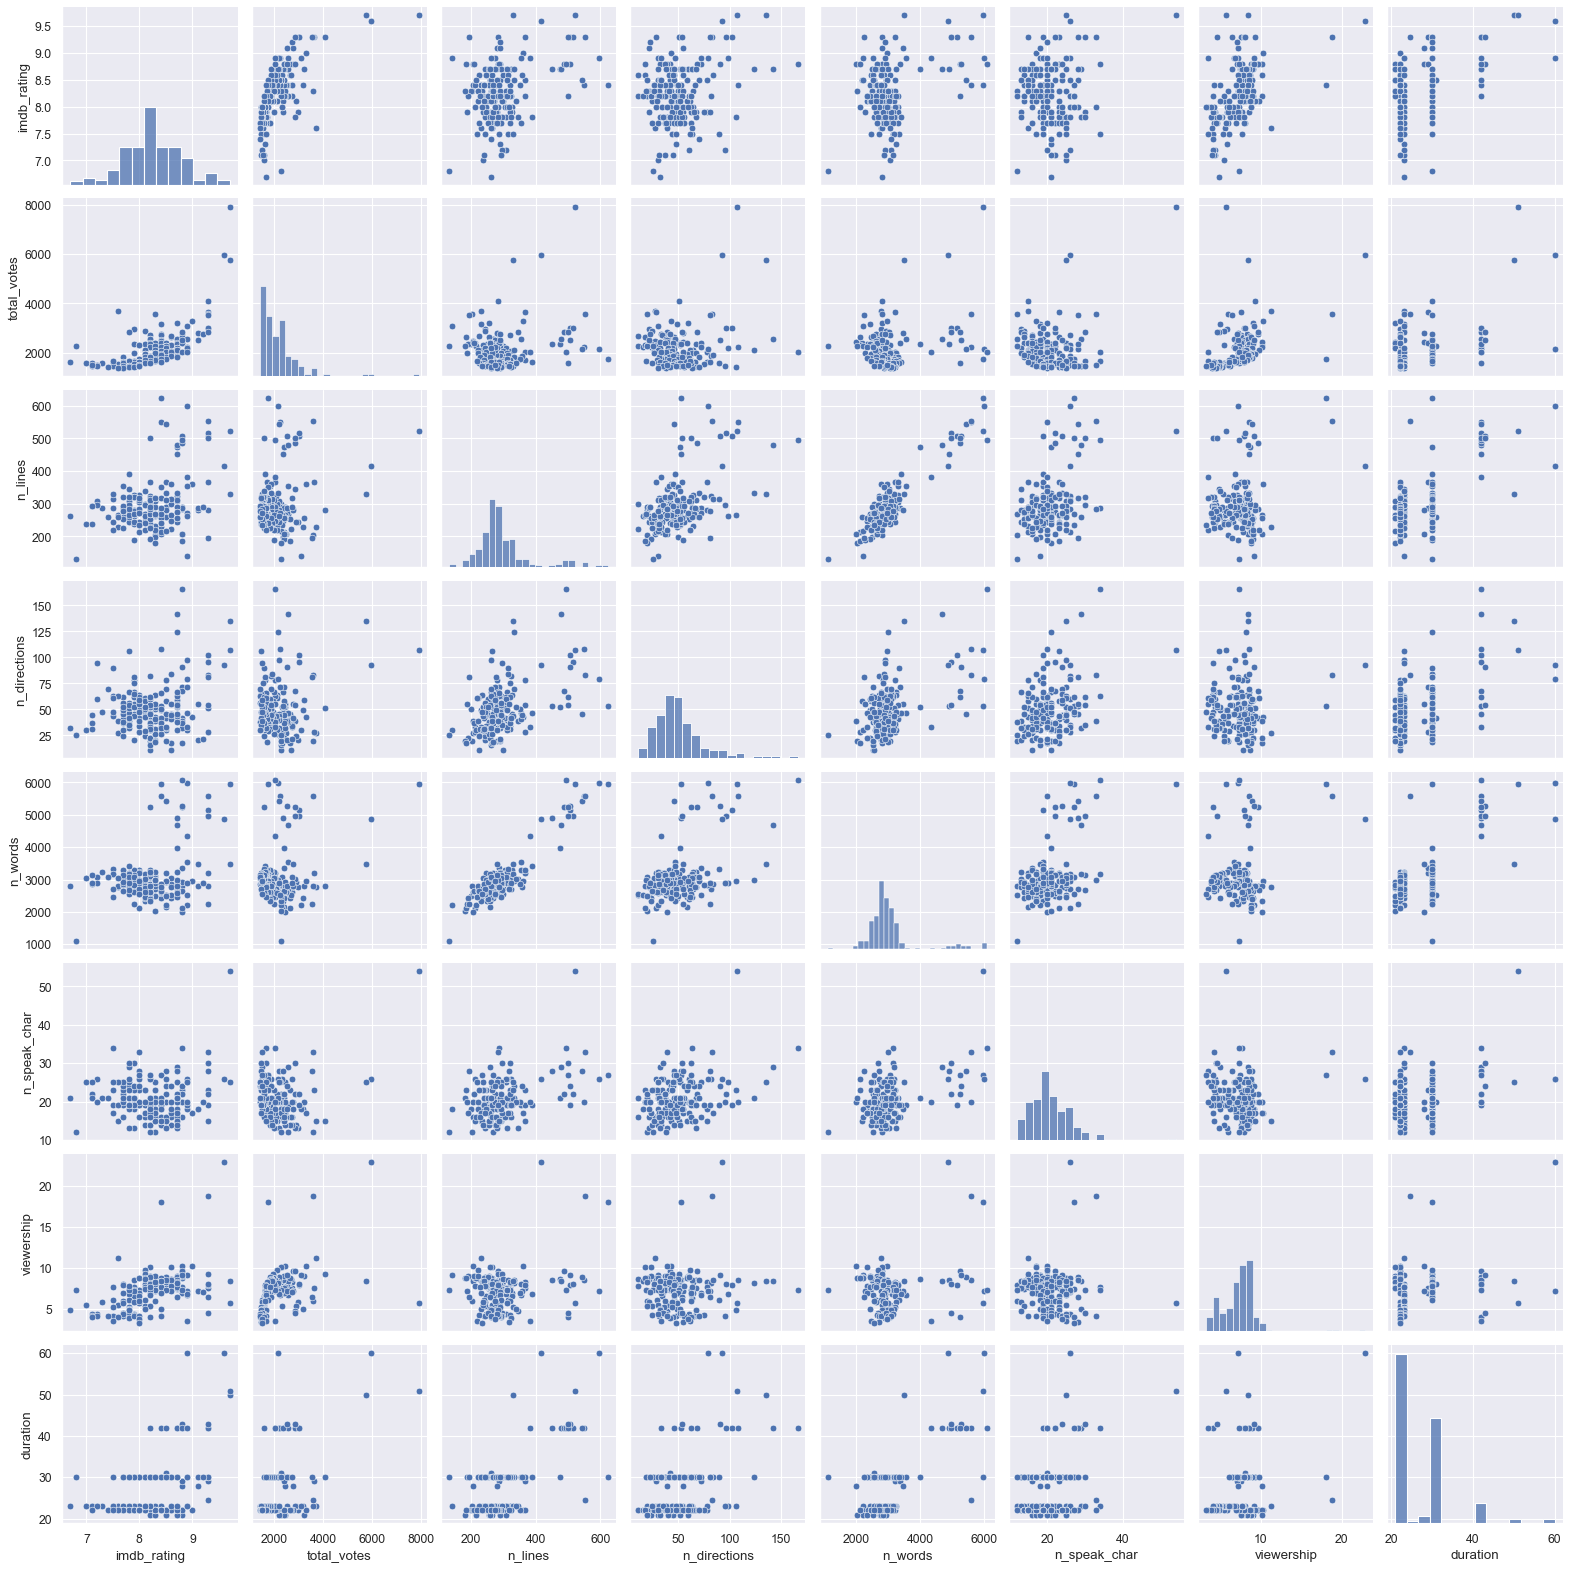

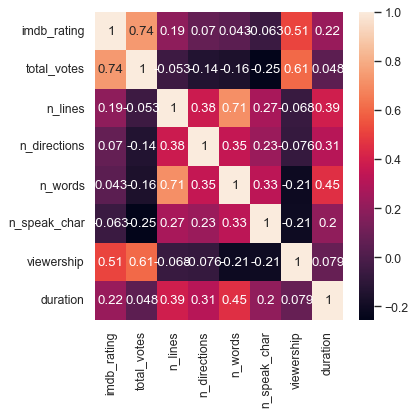

In [11]:
# Show pairwise plot and correlation matrix
get_correlation(df)

Based on the above graphs, there are several key takeaways as follows:

> - There is a very strong relationship between *imdb_rating* and *total_votes*. Additionally, there is a strong relationship between *imdb_rating* and *viewership*.
> - There is strong relationship between *total_votes* and *viewership*.
> - There is a very strong relationship between *n_lines* and *n_words*.
> - There is strong relationship between *n_words* and *duration*.
> - *imdb_rating* is a nearly normal distribution.
> - *n_lines* and *n_directions* have a weak relationship.
> - *imdb_rating* and *n_lines*, *n_directions*, *n_words* and *n_speak_char* have virtually no relationship.

<img src="spearman_interpretation.png" width=600>

The image above provides a view of the Spearman correlation coefficient and what the correlation coefficients values mean (values which can be seen in the heatmap). Spearman correlation coefficient is a non-parametric correlation coefficient that measures montonic relationships rather than  linear relationships. Pearson's correlation also considers that the data is approximiately normally distributed which we are unsure about. It is also easier to consider a montonic relationship in our data rather than a linear relationship as some of our data might not represent any type of linear relationship. Spearmans correlation coefficient is therefore the better correlation coefficient to use to measure the correlation among our features. 

### <a id=24> 2.4. Feature Extraction </a>

This section involves using statistical tools to analyse and identify the pertinent features for our target variable *imdb_rating*. New features will be added here as well as other features that will be extracted.

#### 2.4.1 Basic Extraction

As a preliminary exploration of the data at hand, we have identified through statistical analysis several interesting relationships among features. Namely:

- The *imdb_rating* of the preceding episode has an effect on the *imdb_rating* of the following episode, as it can serve as an indicator of the overall quality and coherence of the series.
- The number of *writers*, *main_chars* and *guest_stars* that are in each episode appear to increas the *imdb_rating* since the collaboration among playwrights and involvement of well-known celebrities can impact the *imdb_rating*.
- For each *writer*, *director* and *main_char* in the episode, the average, minimum and maximum rating of the data from the person's works prior to the release of the current title also impacts the *imdb_rating*. These features offer a basic revelation of the record of writers, directors and main characters, the major contributors of an episode who arguably influence the episode.
- For each *writer*, *director* and *main_char* in the regarded episode, the difference between the average of the person's works and the average of all the episodes in The Office (US), based on the data up to the airdate impacts the *imdb_rating*. This demonstrates to what extent the concerned person may outperform the average level.

#### 2.4.2 Text Analysis 

Furthermore, to untangle the names of episodes and contributors, we have constructed a benchmark of text using the names of the top-rated episodes and series on IMDB (time-sensitively garnered by the web-scrapping snippet provided before), as well as the keywords that appeared in Google Year In Search from 2004 to 2014. 

In [12]:
# Top highest rating episode name
def get_all_names(urls):
    episode_name, series_name = [],[]
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for h in soup.find_all('small', {'class': 'text-primary unbold'}):
            if h:
                episode_name.append(h.find_next_sibling('a').text)
        for h in soup.find_all('span', {'class': 'lister-item-index unbold text-primary'}):
            hh = h.find_next_sibling('a')
            if hh:
                series_name.append(hh.text)
    names = set(series_name + episode_name)
    
    return list(sorted(names))

# Get the list of keywords appeared in Google Year In Search from 2004 to 2014
def read_and_split_by_pattern(filename):
    word_list = []
    with open(filename, 'r') as f:
        for line in f:
            words = re.split(r'\d+\)', line)
            for word in words:
                if word.strip():
                    word_list.append(word.strip())
    return set(word_list)


# Top 50 TV Episode, Rating Count at least 1,000
url = 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=1000,&sort=user_rating,desc'
# Top 50 TV Episode, Rating Count at least 10,000
url2= 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=10000,&sort=user_rating,desc'
# Top 50 TV Episode
url3= 'https://www.imdb.com/list/ls058613627/'

basis = list(sorted(read_and_split_by_pattern('YearInSearch.txt').union(get_all_names((url, url2, url3)))))

Using the benchmark as a reference, we calculate by a pre-trained NLP model the similarity for the names of episodes and contributors. The similarity metric indicates how closely aligned these names are with trendy names that have street-cred.

#### 2.4.3 Observation and Enlightenment for Data Selection

These features, sequentially, are generated by the following function and stored in DataFrame columns labelled as: *writer, imdb_rating, total_votes, n_lines, n_directions,
n_words, n_speak_char, main_chars, director, rating_cat,
guest_stars, viewership, duration, imdb_rating_prev,
writer_mean_rating, writer_min_rating, writer_max_rating,
writer_diff_rating, director_mean_rating, director_min_rating,
director_max_rating, director_diff_rating, main_chars_mean_rating,
main_chars_min_rating, main_chars_max_rating,
main_chars_diff_rating, ep_name_flag, writer_count,
writer_pop_rate, main_chars_count, main_chars_pop_rate,
guest_stars_count, guest_stars_pop_rate, year, month,
air_day_of_week*.

In [13]:
def extract_feature(df, data):
    """
    Parameters
    ----------
    df: existing dataframe (pd.DataFrame).
    data: existing raw data (pd.DataFrame).
    
    Returns
    -------
    df: existing dataframe with additional features (pd.DataFrame).
    dictionary: dictionary with mean, min, and max ratings by writer, director, and main character (pd.dictionary).
    """
    # Rating and total_votes from previous episode
    df['imdb_rating_prev'] = df['imdb_rating'].shift(1)

    # Retrieve mean_rating, max_rating, and min_rating from writer, director, and main_chars
    dictionary = {'writer': pd.DataFrame(), 'director': pd.DataFrame(), 'main_chars': pd.DataFrame()}
    for col in dictionary.keys():
        dictionary[col] = (data.set_index(['air_date', 'imdb_rating']) \
                           [col].str.split(';\s*', expand=True) \
                           .stack() \
                           .reset_index() \
                           .drop(columns='level_2') \
                           .pivot_table(index=['air_date'], columns=0))
        dictionary[col] = dictionary[col]['imdb_rating'].reset_index()

        df[col + '_mean_rating'] = df.apply(lambda x: np.nanmean(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])),
                                            axis=1)
        df[col + '_min_rating'] = df.apply(lambda x: np.nanmin(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1)
        df[col + '_max_rating'] = df.apply(lambda x: np.nanmax(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1)
        df[col + '_diff_rating'] = df.apply(lambda x: np.nanmean(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                            - np.nanmean(data[data['air_date'] < x['air_date']]['imdb_rating']) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1).fillna(0)
    
    # Identifier whether the episode_name is similar to the top highest rating episode/_name
    def calculate_similarity(string_A, list_B_docs):
        string_A_doc = nlp(string_A)
        similarities = []
        for doc in list_B_docs:
            if doc.vector_norm:
                similarities.append(string_A_doc.similarity(doc))
        return max(similarities) if similarities else 0.0
    
    list_B_docs = [nlp(phrase) for phrase in basis]
    df['ep_name_score'] = df['episode_name'].apply(lambda x:
                                                   np.nan if x in basis else calculate_similarity(x, list_B_docs))
    
    # Count the number/popularity of writer, main_chars, and guest_stars
    for col in ['writer', 'main_chars', 'guest_stars']:
        df[col + '_count'] = df[col].apply(lambda x: len(x) if x[0] != 'null' else 0)
        df[col + '_pop_rate'] = df[col].apply(lambda x: 
                                              sum([calculate_similarity(string, list_B_docs) for string in x])/len(x))
    
    # Convert dates to a quantifiable type
    df['air_date'] = pd.to_datetime(df['air_date'])
    df['year'] = df['air_date'].dt.year.astype(str)
    df['month'] = df['air_date'].dt.month.astype(str)
    df['air_day_of_week'] = df['air_date'].dt.day_name()
    
    # Drop columns which we have extracted info from
    df = df.drop(columns=['air_date', 'episode_name'])

    return df, dictionary

df, dictionary = extract_feature(df, data)

We have identified null values in the data related to contributors who appear for the first time due to the absence of historical data. Additionally, we intentionally generate NaN values for similarity scores when the episode's name appears in the top-rated list to evade data leakage.

This leads to the topic of *imputation*, namely, to fill null cells. The most used method, which replaces all with 0, fails in this case because it will considerably penalise those with NaNs since 0 is an outlier that lies far from the distribution of ratings and thereby skews the data. Alternatively, we consider filling each NaN with the average of its column to assign a relatively neutral score to those without enough prescient knowledge, despite the discrimination possibly involved.

Below we use the correlation on specific features in our dataframe. Particularly, these are features that we identified previously with low correlation with regards to *imdb_rating* and might be removed. Here we examine them specifically.

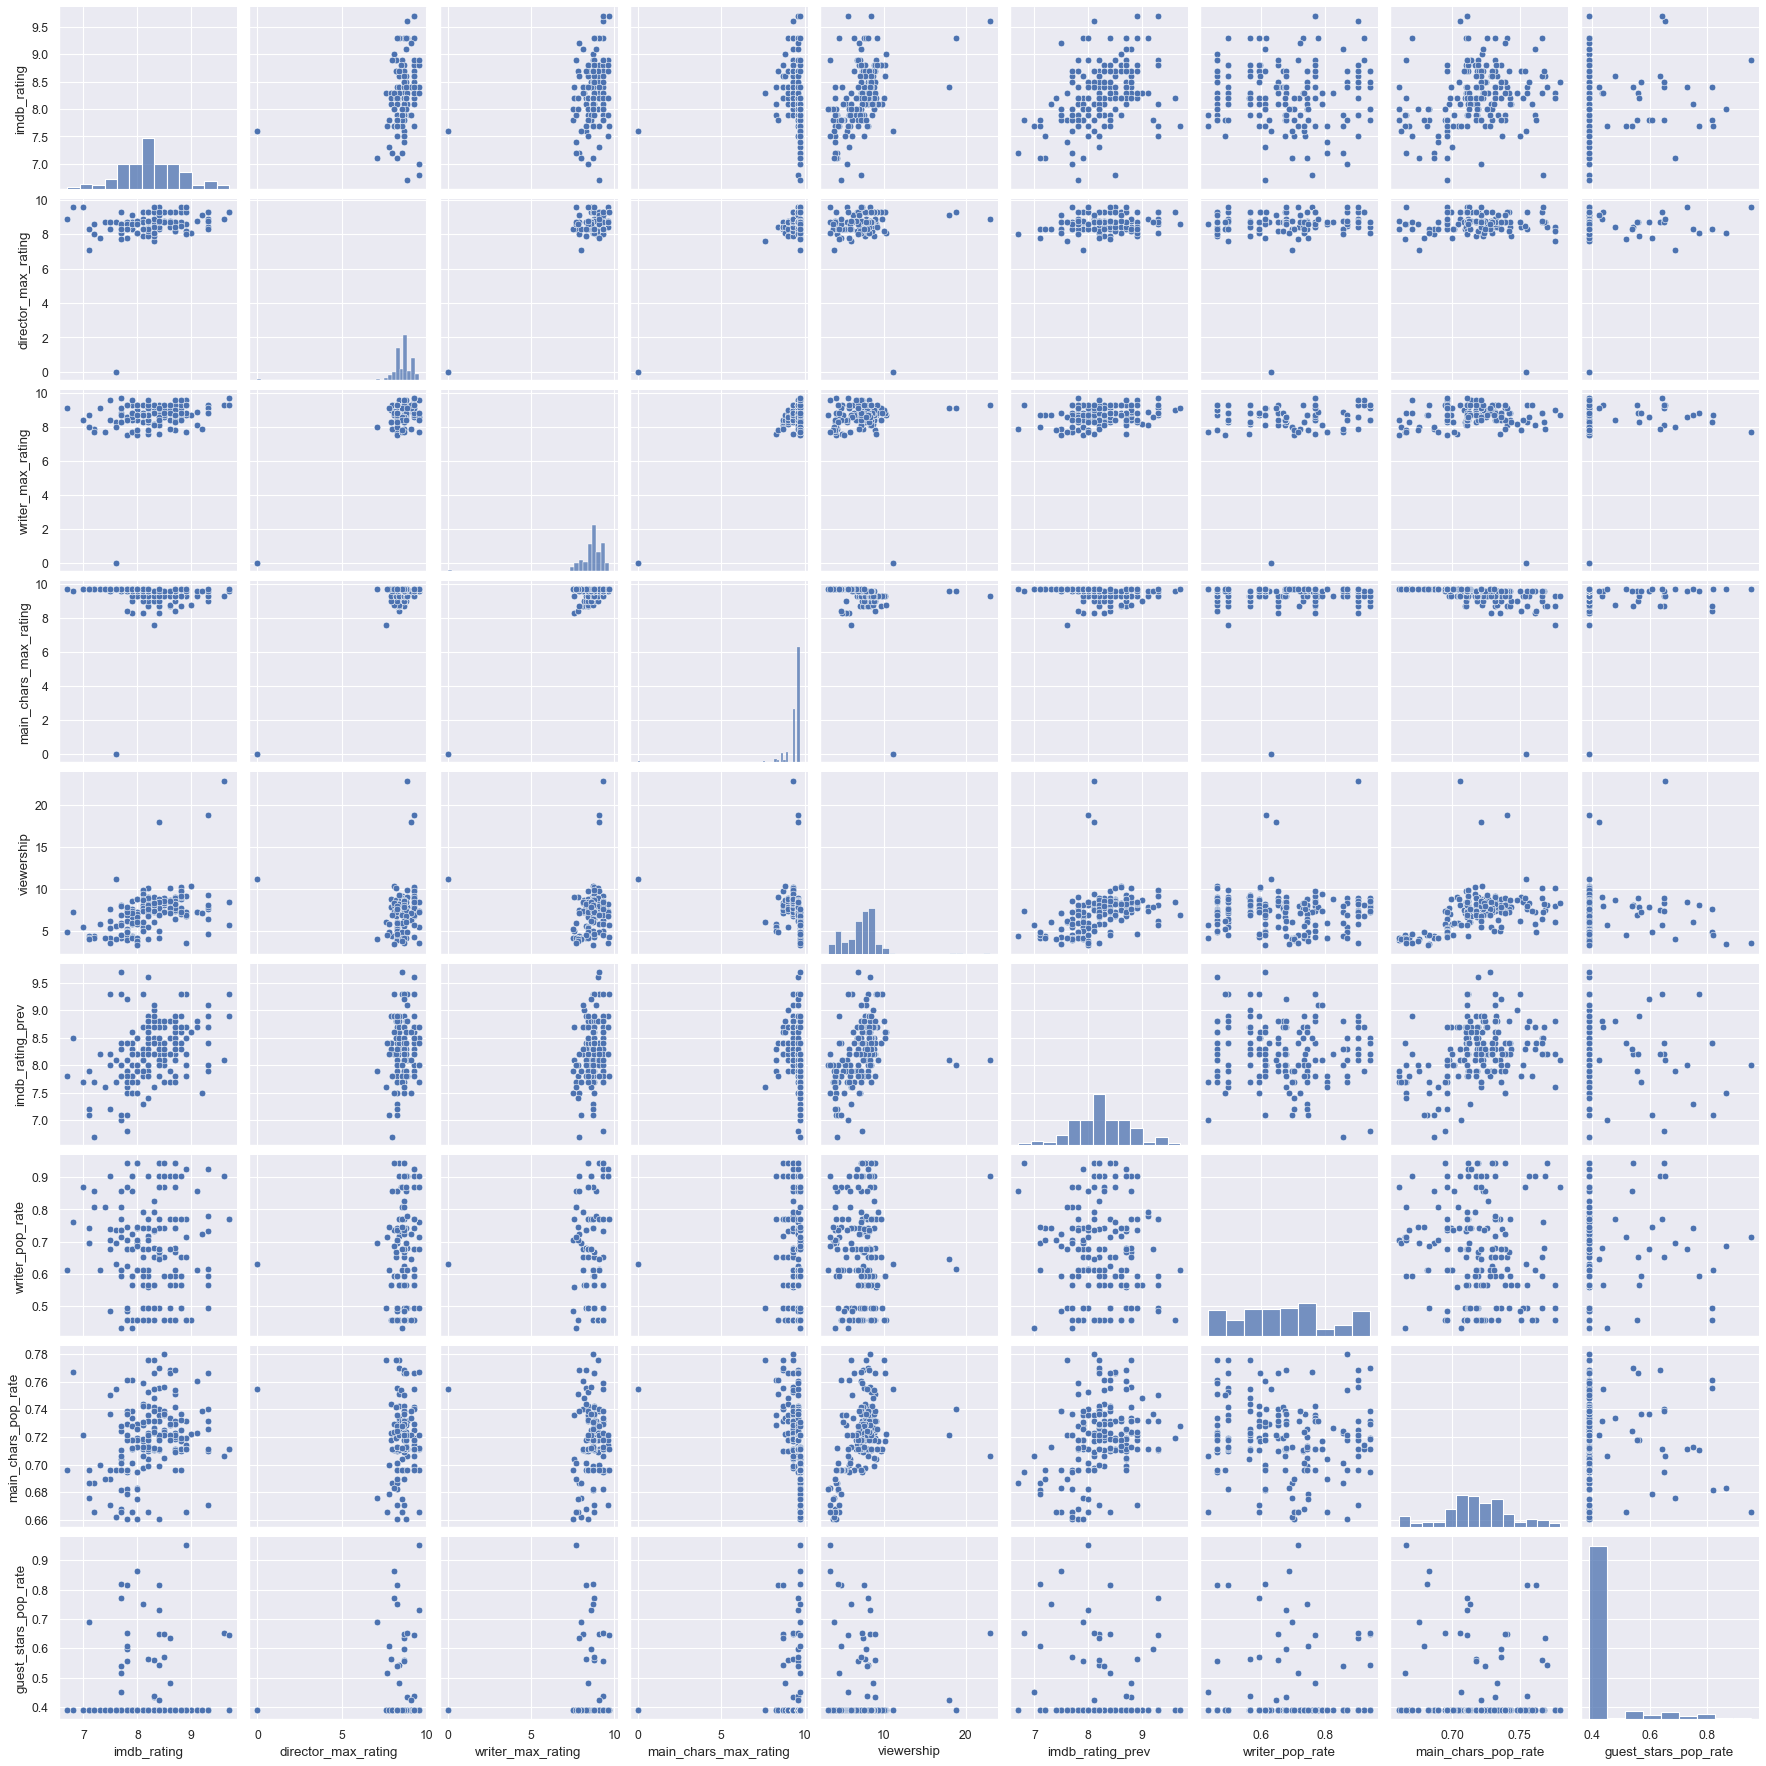

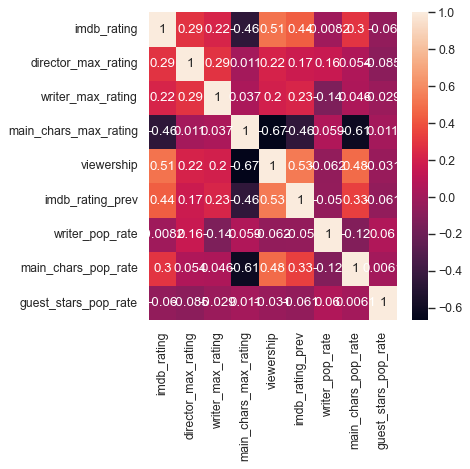

In [14]:
# Show pairwise plot and correlation matrix
get_correlation(df[['imdb_rating', 'director_max_rating', 'writer_max_rating', 'main_chars_max_rating',
                    'viewership', 'imdb_rating_prev', 'writer_pop_rate', 'main_chars_pop_rate', 'guest_stars_pop_rate']])

By scrutinizing the correlations above, we note weak correlations between the *imdb_rating* and some of our features, and strong correlations among some features themselves. Since a weak correlation to the target implies that the variable of concern might be irrelevant, and a significant correlation within features suggests some redundant dimensions in the matrix, the visualization of correlations serves as a clue for future data selection.

### <a id=25> 2.5. Feature Scaling and Selection </a>

The following section standardizes the numerical data and one hot encodes the categorical data. The following classes and function are defined to suppor this process:
- The class `MultiHotEncoder` is developed to encode categorical data that contains multiple values (list of string) instead of a single value (string). E.g., ['A', 'B', 'C']. MultiHotEncoder will recognize this as 3 values instead of one single value ('A, B, C').
- The class `RenameColumns` is used to create standard column names. Since we used two datasets and have create new columns, it is best that throughout the pipeline all columns have standard names. This will also provide easier access to features throughout the pipeline. This standard, for our purposes, is to have a column name where all letters are lowercase, there is an underscore between words, and that there are no prefixes.
- A function `preprocess` that standardizes the numerical data and one hot encodes the numerical data.

The class `MultiHotEncoder` utilizes `MultiLabelBinarizer` from sklearn to encode the categorical columns that contains multi values, not only a single value. The main reason behind the development of this class instead of using `MultiLabelBinarizer` directly is because the aforementioned class can only convert one column every time it is called. However, there are more than one columns that we want to convert using the pipeline; therefore, we need another class which can contain a for-loop there for every single column that we want to encode and merge them at the end. `MultiHotEncoder` contains 2 functions: fit and transform. The fit function encodes every categorical columns, while the transform function merge them together and return them as pandas dataframe.

In [15]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """
    Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`.
    Reference: https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer
    """
    
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.labels = list()

    def fit(self, X:pd.DataFrame, y=None):
        for col in X.columns: # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.loc[:, col])
            self.mlbs.append(mlb)
            self.labels.append([col[0] + '_' + x for x in mlb.classes_])
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        col_names = []
        for x in self.labels:
            col_names.extend(x)
            
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))
        result = np.concatenate(result, axis=1)
        df_result = pd.DataFrame(result, columns=col_names)
        df_result.index = X.index
        return df_result

The following class `RenameColumns` has two functions, fit and transform. The function fit, simple returns an instance of the class itself. The function transform is the key reason why this class is needed. This function will transform the names of the columns to the same standard used in the original dataset. This standard is described above in the first bullet point. To go deeper into why this is necessary, in the pipeline, the outputs are numpy arrays with our features associated with numbers instead of their column names. We then convert this back to a pandas dataframe, however, now the names of the columns are incorrect. This function will then standardize them back to how they were in the original dataset so that all the names are the same across the pipeline. 

In [16]:
class RenameColumns(BaseEstimator, TransformerMixin):
    """
    Standardize the column names of pd.DataFrame output of every pipeline step.
    E.g., num_cols__total_votes --> total_votes
    """
    
    def fit(self, X:pd.DataFrame, y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        new_cols = [x.split('__')[-1] for x in X.columns]
        result = X.copy()
        result.columns = new_cols
        return result

The following function `preprocess` is the finalization of our data processing. Essentially the function has two main goals, to standardize the numerical values and to one hot encode the categorical values. However, this function also creates the pipeline for our model. The following is how each part of the pipeline is created:

1. **num_pipe**: This is where numerical values are scaled and standardized.

    * `SimpleImputer`: This is used to complete any missing values in the dataset. Particularly, the mean value of the numerical data is used to fill in missing values. Since the dataset is not large, a median or most frequent value would not be as appropriate as a the mean, since a median or most frequent number of the dataset may not represent the data well when filling in missing values. Adding a constant would also provide poor estimation and is not as flexible for any datasets and would require estimating the value based on assumptions of the data.
    * `StandardScaler`: This scales all the numerical data by subtracting the mean and dividing by the standard deviation of the column. This allows all the numerical data to be normalized and therefore future computations and model fitting will be more consistent.
    * `PowerTransformer`: This ensures that the data is closer to a Gaussian-like distribution. Each feature will be closer to a standard normal distribution. In particular, the yeo-johnson method is used as it accommodates for positive and negative values in our columns. Box-cox is another option, however, this only includes positive values. Therefore, yeo-johnson is the more flexible method and is preferred.

2. **cat_pipe**: This is the part of the pipleine that endoces the categorical data.

    * `MultiHotEncoder`: This class is used to one hot encode our data. The features that are one hot encoded will be features such as *writers*, *main_chars*, *guest_stars* and *director*. This will result in more features as each director, writer, main character, and guest star will each have their own column.

3. **pca_pipe**: This is where the dimensions of data are reduced.

    * PCA (Principal Component Analysis): The class, imported from sklearn.decomposition, is included in an effort to reduce the dimensionality of data while preserving important information from the features. This method is underlined by the SVD (Singular Value Decomposition) algorithm, which decomposed a given matrix into orthogonal bases ranked by the value of their corresponding singular values, indicators for the importance of each basis. On the ground of that, only a certain number, *n_components* (a hyperparameter of the PCA function that we will tune and determine shortly), of bases remain, on which the data fed into PCA are approximated.
    * pattern: A Regex pattern that filters out the columns not in *cols_preserved*.

4. **pipeline**: This sets up the pipeline for the entire model. There are many parts of this pipeline, they are all explained below:

    * scaling: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "scaling" in our pipeline, we are only referring to the part of the pipeline **num_pipe** which contains our numerical data. The other features, which are categorical, will be skipped but still included in the rest of the pipeline. 
    * rename_cols1: Here we use the class `RenameColumns` to standardize the names as through the pipeline we are receiving numpy arrays that are converted to pandas dataframes with slightly incorrect associated names. This function is used multiple times throughout this final pipeline creation.
    * encode: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "encode" in our pipeline, we are only referring to the part of the pipeline **cat_pipe** which contains our categorical data. The other features, which are numerical will be skipped but still included in the rest of the pipeline.
    * rename_cols2: This has the same functionality as rename_cols1.
    * pca: Here, selected by make_column_selector, columns that conform to pattern will be processed by **pca_pipe**, whereas the others will pass through unchanged.
    * rename_cols2: This has the same functionality as rename_cols1.
    * model: This is where our final regression model will be placed in the pipeline.

In [17]:
def preprocess(model, num_cols, cat_cols, cols_preserved):
    """
    Parameters
    ----------
    model: machine learning model (sklearn model).
    num_cols: numerical columns that are going to be scaled (list).
    cat_cols: categorical columns that are going to be encoded (list).
    cols_preserved: list of columns that are going to be preserved (high feature importance);
                    PCA will be performed to other columns (list).
    
    Returns
    -------
    pipeline: sklearn pipeline.
    """
    
    num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('num_scale', StandardScaler()),
    ('num_transform', PowerTransformer(method='yeo-johnson'))
    ])
    
    cat_pipe = Pipeline([
    ('cat_encode', MultiHotEncoder())
    ])
    
    pca_pipe = Pipeline([
    ('pca', PCA())
    ])
    non_pca_cols = '|'.join(x for x in (cols_preserved))
    pattern = f'^(?!.*(?:{non_pca_cols})$).*$' # Regex string pattern to filter columns that ends with pca_cols
    
    pipeline = Pipeline([
        ('scaling', ColumnTransformer([
            ('num_cols', num_pipe, num_cols)], remainder='passthrough')),
        ('rename_cols1', RenameColumns()),
        ('encode', ColumnTransformer([
            ('cat_cols', cat_pipe, cat_cols)], remainder='passthrough')),
        ('rename_cols2', RenameColumns()),
        ('reduce_dim', ColumnTransformer([('pca_cols', pca_pipe, make_column_selector(pattern=pattern))]
                                  , remainder='passthrough')),
        ('rename_cols3', RenameColumns()),
        ('model', model)
    ])

    return pipeline

## <a id=3> 3. Model Fitting and Tuning </a>

This section defines the regression model that will be used to fit and make the prediction about what features might provide the best new episode of The Office (US) based on the IMDB rating. There are multiple functions employed to help fit the model and to help demonstrate the features that will contribute to a higher IMDB rating. The model used is the Random Forest Regressor, as this provides the best RMSE and an overall better $R^2$ score. This regression model was also determined by testing other models and investigating which models would produce the best results and which models would have less underfitting or overfitting. Overall the Random Forest Regressor turned out to be the best model. The features used, validation, and hyperparameter tuning are all presented in this section of the report. 

- [**3.1. Testing Models**](#31): Describes which other models were tested and why they were not used.
- [**3.2. Model Explanation**](#32): A high level overview of what the Random Forest Regressor is.
- [**3.3. Model Preparation**](#33): Functions are created to ensure that the model can be fitted and hyperparameters can be tuned.
- [**3.4. Model Fitting**](#34): Fitting the model to our data.
- [**3.5. Our Model Explained**](#35): An explanation of our specific model and it's predictive capability and performance factors.

### <a id=31> 3.1 Testing Models </a>

The following explains which models were tested, the results from each model, and why they were not used:

1. **Linear Regression**: Linear regression was the first model to be tested. The model fit the training data, but with an RMSE of approximately 0.38. This is not particularly high, as we would prefer the RMSE to be approximately 0-0.25. There are two other reasons that this model was not chosen. Firstly, the data is not linear. Linear regression, by it's name, works best for data that is linear, and judging by our feature correlation we can see that few of the features (particularly those related to IMDB rating) are not linear. Secondly, linear regression appears to overfit the data. The $R^2$ score is approximately 0.79, whereas the $R^2$ value for the testing set is approximately 0.58. This means the data is fitting the training data well, but when given new datasets, it's performance is mediocre.
2. **Lasso Regression**: After the trial for linear regression, we attempted to introduce a penalty on the absolute values of the coefficients to the objective function of the standard linear regression, originated from the  idea of Lasso regression. The penalty terms in this model are utilized to drive some coefficients to zero, essentially removing them from the model entirely, thereby making it less prone to overfitting. Nevertheless, the crux of the model is still a sophisticated linear correlation, which we have no reason to assume our model should adhere to. As we obtained an unsurprisingly compromising outcome, a $R^2$ score approximately 0.78 for the training set and a $R^2$ value up to 0.61 for the test set, we have also rejected this model.
3. **Decision Tree Regressor**: Next, we tried the decision tree regressor. this method may work better because the dataset does not have to be linear. The model results fit similar to linear regression with a RMSE of approximately 0.37. As mentioned above the ideal range for RMSE is 0-0.25. The value $R^2$ train scored very highly at 0.94 whereas the the test data scored 0.61. This shows again that the the model overfits the data but overall scores better than linear regression but still we will explore other methods. 

### <a id=32> 3.2 Model Explanation </a>

The following section will explain how Random Forest Regressor works. The specifics of our model are then explained in section 3.5.

The Random Forest Regressor is essentially multiple Decision Tree models. To understand Random Forest Regressor, it is necessary to first understand Decision Trees, specifically, Decision Tree Regressor models, as we are undergoing a regression model. In particular, a Decision Tree is simply nested if and else statements. Consider a dataset that has $N$ features with features $\{x_0, x_1,...,x_N\}$, $D$ data points, and one target variable with $D$ data points $\{y^0, y^1,..., y^D\}$. The dataset will be split into two categories at each node, starting at the root node. Each node will have a condition, meaning how the dataset will be split depending on the parent nodes condition (e.g. $x_2 \leq 1$). If you look at all $D$ data points and compare them with this condition, then all data points that meet this condition are in the left node of the split, and all the data points that do not meet the condition are in the right node (e.g. data points with a data point where $x_2 \leq 1$ will be in the right node, and the data points that do not meet this condition will be in the left node). But how do we determine what this condition is? This requires calculating variance reduction. Essentially, the program will run through every feature, and every value that each feature can take, and determine the maximum variance reduction for every possible split that the data set could create. This is done for every node, until the final depth of the tree. Since trees are also used for the Random Forest Regressor, the tree depth will be determined by the **RandomizedSearchCV class from sklearn using the parameter *max_depth***. The variance reduction is calculated as follows

$$Variance Reduction = Var(parent) - \sum{w_i}Var(child)$$

where $Var = \frac{1}{n}\sum_{i=0}^D{(y^i - \hat{y})^2}$, $Var(parent)$ is the variance of the parent node, $Var(child)$ is the variance of the child nodes, and $w_i$ are the weights which are simply the ratio of the number of data points in the child node, divided by the number of data points in the parent node (e.g. for $D$ datapoints, suppose that the split $x_i \leq 1$ results in $\frac{N}{3}$ on the left node which meets the condition and $\frac{2N}{3}$ on the right node. Then the weights would be $\frac{N/2}{N}$ and $\frac{2N/3}{N}$ respectively).

Eventually, the splits will end and there will be nodes with no condition, but rather, these final nodes (leaf nodes) are the data points that are finally split. Our data could be split into more than a single data point per leaf node, as we can have multiple data points per leaf node. Recall that each data point, $\{x_0^0,x_0^1,...x_0^D\},...,\{x_N^0,x_N^1,...,x_N^D\}$, has an associated output value $\{y^0,y^1,...,y^D\}$. Therefore, we end up with a single value (not necessarily a single data point) at each leaf node, which is the average of the output values $y$ at that particular leaf node. Essentially, when a new data point is added to try and create a prediction, the data point will run through the tree checking each condition and moving to the right or left node, until it ends up at a leaf node. Once it gets to a leaf node, the predicted value that is calculated is the average of the output values $y_i$ at that particular leaf node that was decided based on our training data set.

The issue with a regular decision tree is that it is highly sensitive to the training dataset. The model is accustomed quite well to the training dataset, so when new values enter, the optimal conditions are no longer optimal as the variance reduction values would be different for our test set than our training set. This leads to overfitting with our Decision Tree.

To reduce overfitting from the Decision Tree, a Random Forest Regressor is used. The main idea behind the Random Forest Regressor is to create multiple Decision Trees rather than just have the one. This is done by bootstrapping the dataset. Bootstrapping is where we randomly sample $D$ data points, with replacement, from the dataset and create $M$ new datasets. For example, suppose we just have $4$ data points, $\{d_1, d_2, d_3, d_4\}$. Suppose we choose a simple $M$ value, $M=2$. Then we will end up with $2$ datasets that might contain the following data points $\{d_1, d_3, d_3, d_2\}$, and $\{d_4, d_2, d_3, d_4\}$. Once these datasets are created, we choose a number of features to use for each of our $M$ new bootstrapped datasets. The number of features to use is usually the square root of the number of features on the training dataset rounded to the closest whole number. In our example, this would only be $1$ feature, since $\sqrt{2} \approx 1.4142$. Then the feature chosen for each dataset is also a random choice amongst all our features, with replacement. For our example, this could mean we end up with feature $x_1$ and $x_1$, or $x_2$ and $x_3$ for each dataset. 

Now that we have our new datasets created by bootstrapping and our randomized feature selection, we can finally create our forest of decision trees. Each bootstrapped dataset is fitted to the training dataset independently (which is fitted as a regular decision tree described above), which produces $M$ decision trees that each are trained on their respective bootstrapped dataset. In our model we use **RandomizedSearchCV to determine the optimal number $M$ of these datasets, which is also the number of decision trees used, particularly, this is the parameter *n_estimators* in the RandomForestRegressor class in sklearn**. Now, when a new data point is passed through our model, it enters each decision tree individually and each decision tree produces a result. Recall that the result for a decision tree is the average of the outputted data points at that particular leaf node. Since we now have many decision trees, we simply take the average of all the decision trees results, and we have our final prediciton.

The Random Forest Regressor is still prone to overfitting, however, since there are many decision trees and they are all randomized in terms of data points and the features used, the Random Forest Regressor is able to reduce exposure to overfitting. We are taking the average of the result of these multiple trees as well, which further decreases the chances of overfitting. Additionally, we also limit the **max_depth** to 19 and use **5-fold Cross Validation** to reduce the overfitting. 

The snippet of one of our decision trees is provided below:

<img src="snippet_tree.png" width=800 style="float: left;">

### <a id=33> 3.3 Model Preparation </a>

The following section provides preparation for the model. Different functions are created to prepare an effective demonstration of the model. Each function is explained below.

The following function `split` splits the data into training and testing. Particularly we stratify the data to ensure that both the training and testing sets have IMDB ratings that will include all of the ratings range. 

In [18]:
def split(df, label, stratify):
    """
    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    label: target column (string).
    stratify: column indicator for stratified split (string).
    
    Returns
    -------
    X_train: training dataset (pd.DataFrame).
    X_test: testing dataset (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    """
    
    # Raising errors if any of the required columns does not exist
    for col in stratify + label:
        if not col in df.columns:
            raise KeyError(f'Dataframe does not contain {col} column.')  
    
    X = df.drop(columns=label)
    y = df[label]
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=X[stratify])
    X_train = X_train.drop(columns=stratify)
    X_test = X_test.drop(columns=stratify)
    
    return X_train, X_test, y_train, y_test

The following function `model_fit` is where the model is fitted and tested. The model is trained with hyperparameters that are identified by *RandomizedSearchCV*, which will run the model through the parameters given, and identify what hyperparameters will propduce the best model. The model is then fitted to the training data and testing data. The function will also output the mean absolute error, $R^2$ value, and root mean squared error to help determine whether the model is a good fit for the data. Ideally, for each metric, we are looking for the following values based on our data:

- *RMSE*: Between 0.0-0.25
- *MAE*: Between 0.0-0.25
- *$R^2$*: Between 0.7-1.0

The function will also plot the training and testing data along with the Random Forest Regressor line to show visually if our model will fit our data. 

In [19]:
def model_fit(pipeline, X_train, X_test, y_train, y_test):
    """
    Parameters
    ----------
    pipeline: pipeline that incorporates feature selection & scaling (sklearn.pipeline).
    X_train: training dataset (pd.DataFrame).
    X_test: testing dataset (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn.pipeline).
    """
    # Run model
    # Randomized search of Random Forest's hyperparameters, using 3 fold cross validation
    params = {
              'reduce_dim__pca_cols__pca__n_components': range(1, 10, 1),
              'model__n_estimators': range(100, 300, 20),
              'model__max_depth': range(1, 20, 1)
             }
    
    model = RandomizedSearchCV(pipeline, params, n_iter=40, random_state=42,
                               scoring='neg_root_mean_squared_error', cv=5, verbose=0, n_jobs=-1)

    # Fit the grid search model
    model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    
    # Evaluation metrics
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)
    print(f'RMSE (Train | Test): {mean_squared_error(y_train, pred_train, squared=False):.4f} | {mean_squared_error(y_test, pred_test, squared=False):.4f}')
    print(f'MAE (Train | Test): {mean_absolute_error(y_train, pred_train):.4f} | {mean_absolute_error(y_test, pred_test):.4f}')
    print(f'R2 Score (Train | Test): {r2_score(y_train, pred_train):.4f} | {r2_score(y_test, pred_test):.4f}')

    # Plot R2 Score
    plt.figure(figsize=(12, 5))
    
    # Train
    plt.subplot(121)
    plt.scatter(y_train, pred_train, c='b', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Prediction', fontsize=14)
    plt.title(f'R2_train: {r2_score(y_train, pred_train):.3f}', fontsize=14)
    
    # Test
    plt.subplot(122)
    plt.scatter(y_test, pred_test, c='b', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Prediction', fontsize=14)
    plt.title(f'R2_test: {r2_score(y_test, pred_test):.3f}', fontsize=14)
    
    # Plot residual
    plt.figure(figsize=(12, 5))
    
    # Train
    plt.subplot(121)
    sns.residplot(x=model.predict(X_train), y=y_train, scatter_kws={'s': 10, 'color': 'r'})
    plt.xlabel('Prediction')
    plt.ylabel('Residual')
    plt.title('Train')

    # Test
    plt.subplot(122)
    sns.residplot(x=model.predict(X_test), y=y_test, scatter_kws={'s': 10, 'color': 'r'})
    plt.xlabel('Prediction')
    plt.ylabel('Residual')
    plt.title('Test')
    
    # Plot confidence interval using error bars
    plt.figure(figsize=(6, 5))
    
    # Calculate error bar size
    var_unbiased = fci.random_forest_error(best_estimator['model'],
                                           Pipeline(best_estimator.steps[:-2]).fit_transform(X_train),
                                           Pipeline(best_estimator.steps[:-2]).fit_transform(X_test))
    plt.errorbar(y_test, pred_test, yerr=np.sqrt(var_unbiased), fmt='o', ecolor='r', elinewidth=1)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--')
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Prediction', fontsize=14)
    plt.title('Confidence Interval (Test)', fontsize=14)
    plt.show()
    
    return best_estimator

The objective of `show_feature_importances` function is to identify the top k features that impact the model performance the most. `RandomForestRegressor` has *feature_importances_* attribute that provides a list of all features with the importance score ranging from 1 to 0. The logic behind the score calculation is *permutation_importance* class from sklearn that are described as follows:

1. First, the model will fit all the features and make prediction to produce a scoring that is called baseline scoring.
2. Then, one feature will be removed and fitted into the model. The difference of the score produced by this current model and the baseline scoring is the importance score of this feature. In short, permutation importance indicates how impactful a feature is towards the model prediction.
3. Step (2) will be repeated for all the features in the training dataset.

In [20]:
def show_feature_importances(pipeline, topk=10):
    """
    Parameters
    ----------
    pipeline: pipeline with the best estimator for the model (sklearn.pipeline).
    top_k: top k highest features (default_value = 10) (int).
    """
    # Color palette
    colors = sns.light_palette('seagreen', topk, reverse=True)
    
    # Get topk highest features
    df_feature = pd.DataFrame({'name': pipeline['model'].feature_names_in_,
                               'importance': pipeline['model'].feature_importances_}).sort_values('importance', ascending=False)
    df_feature = df_feature.head(topk)
    
    # Plot
    plt.figure(figsize=(8, 3))
    sns.barplot(df_feature, x='importance', y='name', palette=colors)
    plt.title(f'{topk} Most Important Features')
    
    return df_feature

### <a id=34> 3.4 Model Fitting </a>

The following section describes how the model is executed. Note that this only describes the code that is executed to perform the model. The explanation of the Random Forest Regressor is given in section 3.4, and the explanation of the specific model used is explained in section 3.5. 

The following code is where the model, Random Forest Regressor is implemented. The following bullet points explain the code. **Note: The following text does not explain the Random Forest Regressor model, that is explained below the following code snippet.**

- The label is assigned to our *imdb_rating* as this is our output variable y in our data.
- We assign the stratify to the *rating_cat* column in our dataset, which is the *imdb_rating* categories created in section 2.2.
- A list *all_cols* which is all the columns (features) of our dataset excluding our output (*imdb_rating*) and the rating categorical columns.
- A list *remove_cols* contains feature names for features that will be removed from our dataset. These features are removed due to low correlation with *imdb_ratings*, or due to high correlation with each other and therefore other features can be used. For example, the features *n_words* and *n_speak_char* are highly correlated with *n_lines*, where *n_lines* is a numerical feature we keep. 
- The categorical column (feature) names are all assigned to the list *cat_cols*. This is so that when we input them into our model we can encode them with the preprocess function.
- A list *num_cols* of feature names is created to track only the numerical features in the dataset. This is done by subtracting the list *all_cols* mentioned above with the list *cat_cols*, thereby only ending up with the numerical features we wish to use and scale.
- A list of feature names *col_preserved* is created so that within the pipeline, and thereby the preprocess function, these features will not have PCA performed on them as they have high correlation with the columns *imdb_rating*. The specific correlations of these features can be seen in section 2.4.3.
- Then the data is split into training and testing set using the `split` function. This also stratifies our training and test set to ensure that both the training and test datasets contain an roughly even amount of imdb_ratings. E.g. It would be possible that, without stratification, there would be imdb_ratings of only value 7.0 or lower in the training set and of 7.0 and higher in the testing set, resulting in overfitting. 
- Then the model is finally initiated, with parameter *random_state*=42, to ensure that our code is reproduceable.
- Then the pipeline is created with the `preprocess` function (which is explained in section 2.6).
- The function `model_fit` is then called (the function is explained above).
- Finally, the feature importances are shown.


Best Parameters: {'reduce_dim__pca_cols__pca__n_components': 2, 'model__n_estimators': 160, 'model__max_depth': 14}
RMSE (Train | Test): 0.1249 | 0.2466
MAE (Train | Test): 0.0894 | 0.2071
R2 Score (Train | Test): 0.9415 | 0.8288


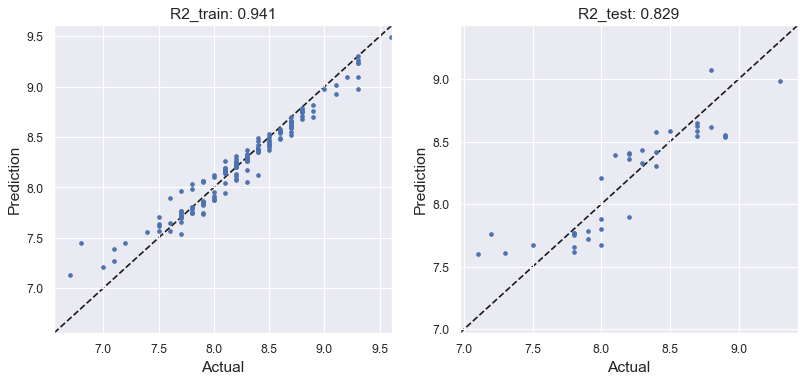

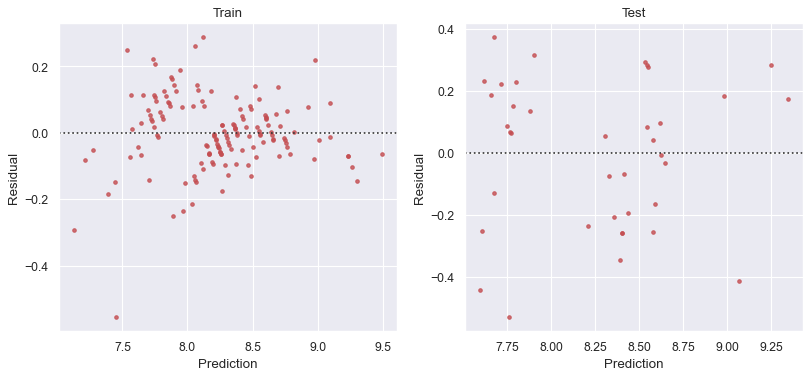

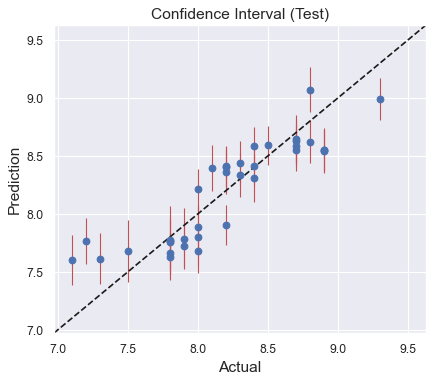

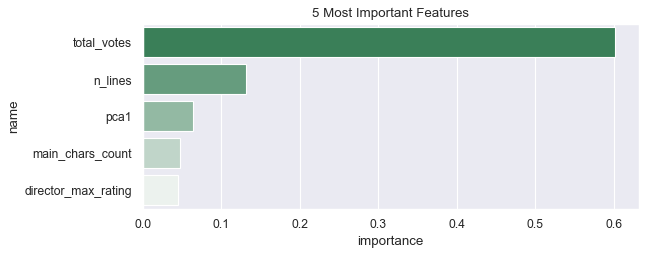

In [21]:
# Label for our dataset
label = ['imdb_rating']

# Identifier column to stratify our split
stratify = ['rating_cat']

# Columns that have low correlation and highly correlated to one of the features in cols_preserved
# e.g. n_words and n_speak_char is highly correlated to n_lines
remove_cols = ['n_words', 'n_directions', 'n_speak_char', 'writer_pop_rate', 'guest_stars_pop_rate',
               'duration', 'air_day_of_week']

# Categorical columns that are going to be encoded
cat_cols = ['writer', 'main_chars', 'director', 'guest_stars']

# Numerical columns that are going to be scaled
num_cols = [x for x in df.columns if not x in label + stratify + cat_cols + remove_cols]

# Features that are going to be preserved; perform PCA on other features
cols_preserved = ['total_votes', 'writer_max_rating', 'director_max_rating', 'main_chars_count',
                  'n_lines', 'year', 'month']

X_train, X_test, y_train, y_test = split(df.drop(columns=remove_cols), label=label, stratify=stratify)

model = RandomForestRegressor(random_state=42, max_features=None)
pipeline = preprocess(model, num_cols, cat_cols, cols_preserved)
final_pipeline = model_fit(pipeline, X_train, X_test, y_train, y_test)
df_feature = show_feature_importances(final_pipeline, topk=5)

### <a id=35> 3.5 Our Model Explanation </a>

Our model, using the Random Forest Regressor, is executed above and the results from the model are shown. This section will discuss the specifics of our model and the final outcome. Pariticularly, this section will detail the metrics/scores produced, hyparameter tuning, graphical representations of the predicted vs. actual data, residuals, prediction intervals and feature importance. This section is organized as follows:

- [**3.5.1. Model Hyperparameters**](#a-id351-351-model-hyperparameters-a)
- [**3.5.2. Model Metric/Scores**](#a-id352-352-model-metricsscores-a)
- [**3.5.3. Model Graphical Representations**](#a-id353-353-model-graphical-representations-a)
- [**3.5.4. Model Feature Importance**](#a-id354-354-model-feature-importance-a)
- [**3.5.5. Positive and Negative Feature Correlation**](#355)

#### <a id=351> 3.5.1 Model Hyperparameters </a>

The following discusses the three hyperparameters that we have tuned for the Random Forest Regressor using the RandomizedSearchCV. Below we examine each hyperparameter:

1. *n_components*: This refers to the rank of the matrix after it has been processed by the PCA algorithm. In other words, if there are N features in the input data, PCA will project those features onto the n most significant bases (i.e., the n eigenvectors with the largest corresponding eigenvalues) obtained from the SVD. This means that N-n dimensions will be discarded, while the remaining n dimensions will be preserved. Increasing *n_components* will retain more comprehensive information from the data, but this comes at the cost of reduced efficiency due to the increased amount of data. Additionally, some features may not be relevant or helpful and can introduce noise, leading to poor performance. Therefore, it is crucial to tune this hyperparameter to achieve the right balance between data loss, efficiency, and potential noise.
2. *n_estimators*: The second hyperparameter we tune is *n_estimators*. Recall that in section 3.2 it is mentioned that *n_estimators* is the number of decision trees in our forest created by Random Forest Regressor. The RandomizedSearchCV takes values 100 to 300 in increments fo 20, meaning that 10 different values can be randomly selected to determine the optimal number of trees. Our model determines that the optimal number of decision trees to create is 160 for our dataset. As mentioned before, this means that our dataset is bootstrapped into 160 datasets, where each dataset will be individually fitted, creating 160 decision trees.
3. *max_depth*: The third and final hyperparameter that is tuned in *max_depth*. This is also mentioned in section 3.2, but essentially the *max_depth* is how deep our decision trees in our forest can go. This means how many levels of nodes we can have in our forest at most. Particularly, RandomizedSearchCV randomly takes values from 1 to 20 to determine our optimal model. Given the optimal forest depth of 14, no more than 14 levels of nodes produce the optimal preditictive value.

#### <a id=352> 3.5.2 Model Metrics/Scores </a>
In section [3.1](#31) we tried and tested Linear Regression and Decision Tree regressor however both did not fit as well as Random Forest Regressor. Our scores for our models are as follows with:

| Metric  | Train Score  | Test Score | Ideal range  |
|---|---|---|---|
|  RMSE | 0.1249  |  0.2466 | 0-0.25  |
|  MAE | 0.0894  | 0.2071  |  0-0.25 |
| $R^2$ |  0.9415 | 0.8288 |  0.7-1 |

The slight difference in the test and train scores could be explained by the model being slightly overfitting. However, we have controlled the *max_depth* in the Random Forest Regressor model and used **5-fold Cross Validation** to reduce this. Our suggestion to further improve our model is to integrate more features, such as the budget, the expenses on advertising, the number of jokes, and the time of each main character in an episode.

#### <a id=353> 3.5.3 Model Graphical Representations </a>

The following discusses the three graphs that are produced above. This excludes the feautre importance which is explained below:

1. **Actual vs. Prediction Graph**: This plot shows how the actual *imdb_ratings* compare to the predicted/fitted data from our training set (graph on the left) and testing set (graph on the right). Ideally, for this type of graph, if the model is perfect, all points will fall onto the diagonal line (dotted line in our graphs). It is noticable that in the training graph (left) that the data points fall near to the diagonal line, indicating that our actual imdb_rating and the predicted imdb_ratings are close to equal for each data point. This results in a higher $R^2$ value of $0.941$. However, we do see that in the testing data, our data points are slightly more dispered away from the diagonal line, meaning that the testing data predictions and actual values for *imdb_ratings* are not always equal for each data point. This of course means a lower $R^2$ score of $0.829$. As explained above, this means the model is overfitting slightly.
2. **Residual Graph**: These graphs plot the residuals of our output data points. Recall that the residual is the difference between the actual imdb_rating and the predicted *imdb_rating* from our training (left) and testing (right) dataset. Therefore, when we plot our output variable's(*imdb_rating*'s) predicted value on the x-axis, and the residual on the y-axis. A perfect predicition model would see all the data points here fall on the line $y=0$. Much like the Actual vs Prediction Graph, this would mean that the actual values and the predicted values of the dataset would be equal, thus ensuring that our model would have perfect prediction performance. The training dataset (left), shows that the points are slightly dispersed around the line $y=0$, however, the furthest points from the line are approximately $0.25$ to $-0.55$. However, once again the testing set is more dispersed, indicating that our model is slightly overfitting. The highest and lowest values are approximately $0.38$ to $-0.57$. However, this dispersion of our training and testing dataset is not greatly different for our data. 
3. **Confidence Interval Graph**: This graph shows the error in our predictions specifically for the testing set, as we want to evaluate the predicitions for new data. It is noticable that the data at lower scores generally has higher error, whereas higher imdb_rating data points have slightly smaller error. This means that we are more confident to predict higher *imdb_ratings* than lower *imdb_ratings*. The error is computed based on infinitesimal jackknife variance as described in [2].

#### <a id=354> 3.5.4 Model Feature Importance </a>

The graph of features importances shows a significant correlation between *total_votes* and imdb_rating of approximately 0.59. This is not suprising given that people are more likely to watch a higher rated episode and therefore vote. Suprisingly, *n_lines* was second most important, the are several possible explanations for this such as the show is more enteraining with lots of dialogue and therefore more jokes. Or that physical interactions with less diaglogue is more entertaining. In conclusion, these are just theories and we lack the data to explain this. However, the next section we will explore the postive and negative importance of each variable to understand the actual impact of the parameters.

#### <a id=355> 3.5.5  Positive and Negative Feature Correlation </a>

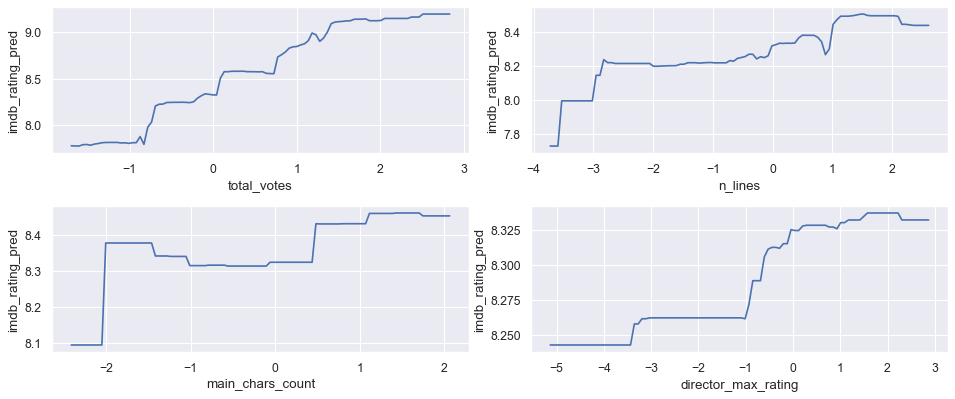

In [22]:
# Find positive or negative correlations from the features
df_training = Pipeline(final_pipeline.steps[:-1]).fit_transform(X_train)
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
fig.tight_layout(w_pad=2, h_pad=2)
x, y = 0, 0

for col in df_feature['name']:
    if not 'pca' in col:
        df_new = pd.DataFrame(columns=df_training.columns)
        df_new.loc[:, col] = np.linspace(df_training[col].min(), df_training[col].max(), num=100)
        for other_col in [x for x in df_training.columns if x != col]:
            df_new.loc[:, other_col] = df_training[other_col].mean()

        df_new['imdb_rating_pred'] = final_pipeline['model'].predict(df_new)
        sns.lineplot(df_new, x=col, y='imdb_rating_pred', ax=ax[x, y])

        if y == 1:
            x += 1
            y = 0
        else:
            y += 1

Based on the above graphs, it can be concluded that total_votes, n_lines, main_chars_count, and director_max_rating are positively correlated with imdb_rating.

The normalized value in above graphs will be denormalized for recommendations in the following section.

## <a id=4> 4. Discussion and Conclusions </a>


Overall, we combined two datasets to retrieve data such as episode name, the name of writers, directors, main characters, and guest stars; total votes, air date, number of spoken lines, number of lines containing a stage direction, number of dialog words, number of different characters with spoken lines, viewership, and duration. By analyzing the existing data, we can gain other information such as the rating of previous episode, the average, lowest, and highest rating by writers, directors, main characters, and guests stars; how good/bad the writers, directors, main characters, and guest stars compared to the average (calculated by taking the difference between the rating obtained and average of rating), the popularity rate of episode name, writers, directors, main characters, and guest stars; as well as the year and month when the episode is aired.

To generate a prediction and gain insights on which factors contribute the most to the imdb rating, we use Random Forest Regressor model. In short, Random Forest Regressor is a group of decision trees which consists of if-else statements to define the imdb rating based on some specific criterias. This model is used because we have identified that there is no linear relationship between variables or combination of variables to imdb rating. Random Forest Regressor can handle this very well because it does not require the assumption that the variables/combination of variables have a linear relationship with imdb rating.

Based on the result, our model is able to produce a relatively good prediction with an error of 0.24 in average. It is also depicted that our model is considerably better at predicting higher imdb rating (>=8) rather than the lower ones (<8). The top 4 features that impact our model's predictions the most are total votes, number of spoken lines, number of main characters, and highest rating by directors.

We will now look at internal variables seperating internal and external variables. We define internal variables as variables that NBC can predetermine and thus fix such as *n_lines*, *director*, and *main_chars*. External variables such as *total_votes* will not be considered because we can only speculate this after the episode airs and therefore there is a large uncertainty. However, we can still provide a recommendation such as focusing on advertisement to increase traction and therefore *total_votes* will be larger.

From [3.5.5](#355), it can be seen that the optimal values for *n_lines* and *main_chars_count* is between 1 and 2. These values will be denormalized in order to obtain the real values for recommendation.

In [23]:
# Find optimal values for n_lines and main_chars_count
for col in ['n_lines', 'main_chars_count']:
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = std + mean
    upper_bound = 2*std + mean
    print(f'{col}: [{int(lower_bound)}, {int(upper_bound)}]')

# Top 3 Directors
df_director_max = pd.DataFrame(dictionary['director'].drop(columns='air_date').max(),
                   columns=['max_rating']).sort_values(by='max_rating', ascending=False).rename_axis(None)
display(df_director_max.head(3))

n_lines: [378, 460]
main_chars_count: [15, 17]


,max_rating
Ken Kwapis,9.7
Paul Feig,9.7
Jeffrey Blitz,9.6


# **Reccomendations**

Internal Variables:

- The optimal **spoken lines** for the new episode are between 378 and 460
- The **director** for the new episode can either be Ken Kwapis, Paul Feig, or Jeffrey Blitz; or combination of them. 
- For the **number of main characters**, we suggest that the new episode casts at least 15 people.

External Variables:
- The higher the popularity of the epsiode the better. Therefore we recommend as much advertising as possible to gain as traction for the episode as possible.

**Disclaimer:** This model is designed to give recomendations for the highest IMDB rating as possible for the reunion episode. Noteworthily there is a disparity between an episode's popularity and it's IMDB rating, and there is not enough evidence to buttress a solid correlation between them. However, a high-rated episode is likely to favour the popularity in general, so for those particularly interested in the popularity, you may use the IMDB rating as an index for popularity, and thus the favourable factors we have firgured out may help. 

## 5. References

[1] Aurelien Geron. 2019. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd. ed.). O'Reilly Media, Inc.

[2] S. Wager, T. Hastie, B. Efron. "Confidence Intervals for Random Forests: The Jackknife and the Infinitesimal Jackknife", Journal of Machine Learning Research vol. 15, pp. 1625-1651, 2014

[3] https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

[4] https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer